In [42]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
# Load the dataset
df = pd.read_csv("Datasets/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .


In [45]:
df.shape

(8551, 4)

In [46]:
# Creating sentence, label lists and adding bert tokens
sentences = df.sentence.values

# adding CLS and SEP tokens at the begining and the end of each sentence for BERT
sentences  = ["[CLS] " + sentence + " [SEP] " for sentence in sentences]
labels = df.label.values

In [47]:
sentences[:10], labels[:10]

(["[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP] ",
  "[CLS] one more pseudo generalization and i 'm giving up . [SEP] ",
  "[CLS] one more pseudo generalization or i 'm giving up . [SEP] ",
  '[CLS] the more we study verbs , the crazier they get . [SEP] ',
  '[CLS] day by day the facts are getting murkier . [SEP] ',
  "[CLS] i 'll fix you a drink . [SEP] ",
  '[CLS] fred watered the plants flat . [SEP] ',
  '[CLS] bill coughed his way out of the restaurant . [SEP] ',
  "[CLS] we 're dancing the night away . [SEP] ",
  '[CLS] herman hammered the metal flat . [SEP] '],
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [48]:
# Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenized sentences: ", tokenized_texts[:10])

Tokenized sentences:  [['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]'], ['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'and', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]'], ['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'or', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]'], ['[CLS]', 'the', 'more', 'we', 'study', 'verbs', ',', 'the', 'cr', '##azi', '##er', 'they', 'get', '.', '[SEP]'], ['[CLS]', 'day', 'by', 'day', 'the', 'facts', 'are', 'getting', 'mu', '##rk', '##ier', '.', '[SEP]'], ['[CLS]', 'i', "'", 'll', 'fix', 'you', 'a', 'drink', '.', '[SEP]'], ['[CLS]', 'fred', 'watered', 'the', 'plants', 'flat', '.', '[SEP]'], ['[CLS]', 'bill', 'coughed', 'his', 'way', 'out', 'of', 'the', 'restaurant', '.', '[SEP]'], ['[CLS]', 'we', "'", 're', 'dancing', 'the', 'night', 'away', '.', '[SEP]'], ['[CLS]', 'herman', 'hammered', 'the', 'metal', 'flat', '.', '[SEP]']]


In [49]:
# Processing the data

MAX_LEN = 128

# use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad our input tokens
def pad_sequences(sequences, max_len, pad_val=0, dtype=torch.long):
    processed = []
    for seq in sequences:
        seq = seq[:max_len] # truncate if longer than max_len
        pad_len = max_len - len(seq)
        if pad_len > 0:
            pad = torch.full((pad_len,), pad_val, dtype=dtype)
            seq = torch.cat([seq, pad])
        processed.append(seq)
    return torch.stack(processed)


In [50]:
input_ids_tensor = []
for id in input_ids:
    input_ids_tensor.append(torch.tensor(id))

labels = torch.tensor(labels)

In [51]:
input_ids_tensor = pad_sequences(input_ids_tensor, MAX_LEN)

In [52]:
input_ids_tensor[:2]

tensor([[  101,  2256,  2814, 24185,  1050,  1005,  1056,  4965,  2023,  4106,
          1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [55]:
# Creating attention masks
attention_masks = []
for seq in input_ids_tensor:
    seq_mask = [float(i>0) for i in seq]  # 1 for real tokens, 0 for padding tokens
    attention_masks.append(seq_mask)
attention_masks = torch.tensor(attention_masks)

In [56]:
# splitting the data into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids_tensor,
                                                                                    labels,
                                                                                    random_state=42,
                                                                                    test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                        input_ids_tensor,
                                                        random_state=42,
                                                        test_size=0.1)

In [58]:
# selecting the batch size and creating the DataLoaders
BATCH_SIZE = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)


In [60]:
#BERT model configuration
from transformers import BertModel, BertConfig

configuration = BertConfig()

model = BertModel(config=configuration)

configuraiton = model.config
configuration

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.53.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [62]:
# Loading the hugging face BERT uncased base model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,  # Number of labels for classification
)  
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [64]:
# Optimizer grouped parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    #Filter for all parameters which don't include bias, gamma or beta
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    # filter for all parameters which include bias, gamma or beta
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

In [65]:
# The hyperparameters for the training loop
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [66]:
# creating the accuracy measurement function to calculate the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [72]:

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [73]:

t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.48363416323523306


Epoch:  25%|██▌       | 1/4 [01:06<03:20, 66.87s/it]

Validation Accuracy: 0.820216049382716
Train loss: 0.29118385413251974


Epoch:  50%|█████     | 2/4 [02:17<02:18, 69.30s/it]

Validation Accuracy: 0.8148148148148148
Train loss: 0.17387131566019473


Epoch:  75%|███████▌  | 3/4 [03:30<01:10, 70.90s/it]

Validation Accuracy: 0.8167438271604938
Train loss: 0.11147348362859726


Epoch: 100%|██████████| 4/4 [04:44<00:00, 71.09s/it]

Validation Accuracy: 0.820216049382716


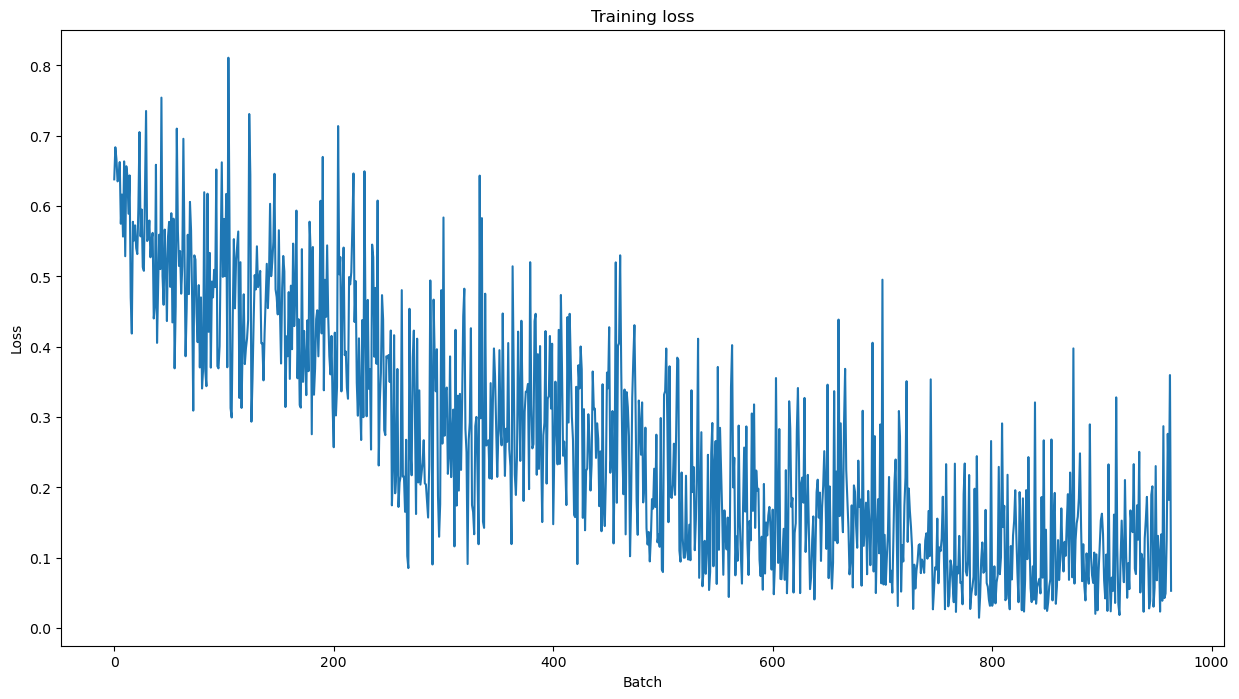

In [74]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [75]:
#loading the holdout dataset
df = pd.read_csv("Datasets/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [81]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids_op = []
for i in input_ids:
  seq = torch.tensor(i)
  input_ids_op.append(seq)
  
  
input_ids = pad_sequences(input_ids_op, MAX_LEN)
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/tmp/ipykernel_10044/3867280845.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_inputs = torch.tensor(input_ids)


In [82]:
#Softmax logits
import numpy as np

def softmax(logits):
    e = np.exp(logits)
    return e / np.sum(e)

In [83]:
import torch
import numpy as np

# Put model in evaluation mode
model.eval()

# Tracking variables
raw_predictions, predicted_classes, true_labels = [], [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Convert input_ids back to words
  b_input_ids = b_input_ids.to('cpu').numpy()
  batch_sentences = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in b_input_ids]

  # Apply softmax function to convert logits into probabilities
  probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

  # The predicted class is the one with the highest probability
  batch_predictions = np.argmax(probabilities, axis=1)

  # Print the sentences and the corresponding predictions for this batch
  for i, sentence in enumerate(batch_sentences):
    print(f"Sentence: {sentence}")
    print(f"Prediction: {logits[i]}")
    print(f"Sofmax probabilities", softmax(logits[i]))
    print(f"Prediction: {batch_predictions[i]}")
    print(f"True label: {label_ids[i]}")

  # Store raw predictions, predicted classes and true labels
  raw_predictions.append(logits)
  predicted_classes.append(batch_predictions)
  true_labels.append(label_ids)

Sentence: somebody just left - guess who.
Prediction: [-2.6748888  2.2254317]
Sofmax probabilities [0.00738919 0.9926108 ]
Prediction: 1
True label: 1
Sentence: they claimed they had settled on something, but it wasn't clear what they had settled on.
Prediction: [-2.8280878  2.2311926]
Sofmax probabilities [0.00631006 0.99368995]
Prediction: 1
True label: 1
Sentence: if sam was going, sally would know where.
Prediction: [-2.8870003  2.47291  ]
Sofmax probabilities [0.00467933 0.9953207 ]
Prediction: 1
True label: 1
Sentence: they're going to serve the guests something, but it's unclear what.
Prediction: [-2.919582   2.4263139]
Sofmax probabilities [0.00474506 0.99525493]
Prediction: 1
True label: 1
Sentence: she's reading. i can't imagine what.
Prediction: [-2.6908042  2.2208035]
Sofmax probabilities [0.00730686 0.9926931 ]
Prediction: 1
True label: 1
Sentence: john said joan saw someone from her graduating class.
Prediction: [-3.0005333  2.4452562]
Sofmax probabilities [0.0042959  0.9